# Ensembles of Estimators: Random Forests

This notion - that multiple overfitting estimators can be combined to reduce called the effect of this overfitting - is what underlies an ensemble method callled _bagging_. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision tress is known as a _random forest_.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

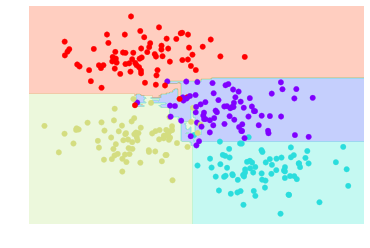

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. 

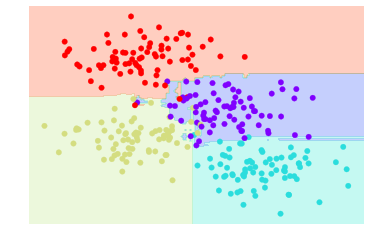

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y)

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, continous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor` and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

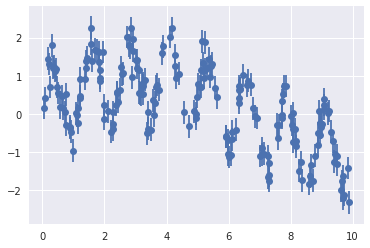

In [8]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

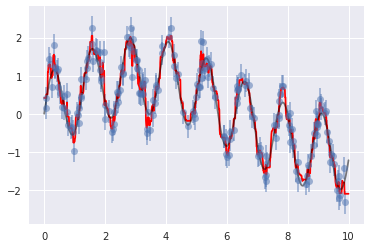

In [12]:
# Using the random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

# Example: Random Forest for Classifying Digits

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

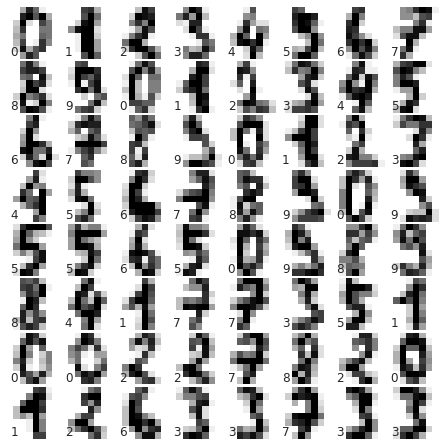

In [22]:
# set up the figure 
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [24]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [25]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.95      0.97        44
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



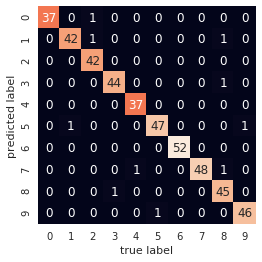

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');